### Using Convolutional Neural Networks (CNN) to classify Pneumonia X-Rays

#### Import packages

In [367]:
#Import general packages
import numpy as np 
import matplotlib.pyplot as plt 
import os
from PIL import Image
import glob 
import cv2
import seaborn as sns

#setting Global random Seed 
import tensorflow as tf
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
                
#Keras and metric packages
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix

In [368]:
#Three folders for data: train, validation, test 

mainDIR = os.listdir('../Metis/chest_xray')
print(mainDIR)

['.DS_Store', 'chest_xray', '__MACOSX']


In [369]:
train_folder= '../Metis/chest_xray/chest_xray/train/'
val_folder = '../Metis/chest_xray/chest_xray/val/'
test_folder = '../Metis/chest_xray/chest_xray/test/'

Rescale is a value by which we will multiply the data before any other processing. 
The original images consist in RGB coefficients in the 0-255, but those values would be too high for the model to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor

In [370]:
#Data Generator
#The function ImageDataGenerator augments your image by iterating 
#through image as your CNN is getting ready to process that image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization

It may be helpful to hold out some of the training data as a validation set to get continuous feedback on epoch performance while training (or even to use for early stopping!)

In [371]:
#Apply datagen to datasets 
#Val and test have same data transformations since val dataset will be proxy for test 

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64, 64),
                                                 batch_size = 128,
                                                 class_mode = 'binary')

validation_set = test_datagen.flow_from_directory(val_folder,
                                                        target_size=(64, 64),
                                                        batch_size=128,
                                                        class_mode='binary')

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = (64, 64),
                                            batch_size = 128,
                                            class_mode = 'binary')

Found 3786 images belonging to 2 classes.
Found 1446 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### EDA

In [213]:
#Creating paths to access data 
#Making a list of files to get counts for assessing class balance
#Training data folder 
DIR = '../Metis/chest_xray/chest_xray/train/NORMAL'
DIR2 = '../Metis/chest_xray/chest_xray/train/PNEUMONIA'
#create a list comp of each file in the folder
Normal = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]) 
Pneumonia = len([name for name in os.listdir(DIR2) if os.path.isfile(os.path.join(DIR2, name))])

In [214]:
#Testing data folder 
DIR3 = '../Metis/chest_xray/chest_xray/test/NORMAL'
DIR4 = '../Metis/chest_xray/chest_xray/test/PNEUMONIA'
#create a list comp of each file in the folder
Normal1 = len([name for name in os.listdir(DIR3) if os.path.isfile(os.path.join(DIR3, name))])
Pneumonia1 = len([name for name in os.listdir(DIR4) if os.path.isfile(os.path.join(DIR4, name))])

In [215]:
#Validation data folder
DIR5 = '../Metis/chest_xray/chest_xray/val/NORMAL'
DIR6 = '../Metis/chest_xray/chest_xray/val/PNEUMONIA'
#create a list comp of each file in the folder
Normal2 = len([name for name in os.listdir(DIR5) if os.path.isfile(os.path.join(DIR5, name))])
Pneumonia2 = len([name for name in os.listdir(DIR6) if os.path.isfile(os.path.join(DIR6, name))])

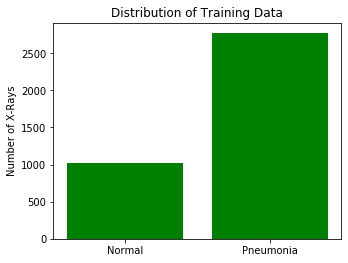

In [372]:
#Plot number of images in classes in training data set 
fig = plt.figure(figsize=[4, 3])
ax = fig.add_axes([0,0,1,1])
Classes = ['Normal', 'Pneumonia']
Numbers = [Normal, Pneumonia]
ax.bar(Classes,Numbers,color = 'g')
ax.set_ylabel('Number of X-Rays')
ax.set_title('Distribution of Training Data')
plt.show()

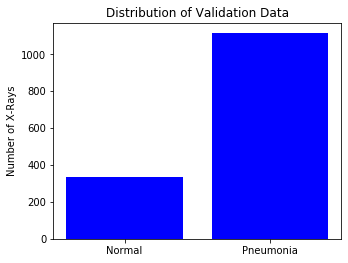

In [373]:
#Plot number of images in classes in validation data set 
fig = plt.figure(figsize=[4, 3])
ax = fig.add_axes([0,0,1,1])
Classes = ['Normal', 'Pneumonia']
Numbers = [Normal2, Pneumonia2]
ax.bar(Classes,Numbers,color = 'b')
ax.set_ylabel('Number of X-Rays')
ax.set_title('Distribution of Validation Data')
plt.show()

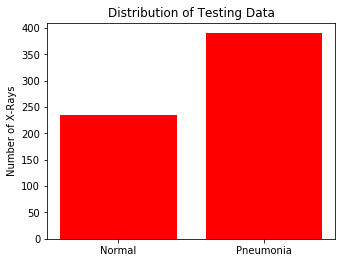

In [374]:
#Plot number of images in classes in testing data set 
fig = plt.figure(figsize=[4, 3])
ax = fig.add_axes([0,0,1,1])
Classes = ['Normal', 'Pneumonia']
Numbers = [Normal1, Pneumonia1]
ax.bar(Classes,Numbers,color = 'r')
ax.set_ylabel('Number of X-Rays')
ax.set_title('Distribution of Testing Data')
plt.show()

#### Sample Images from Each Class 

Normal


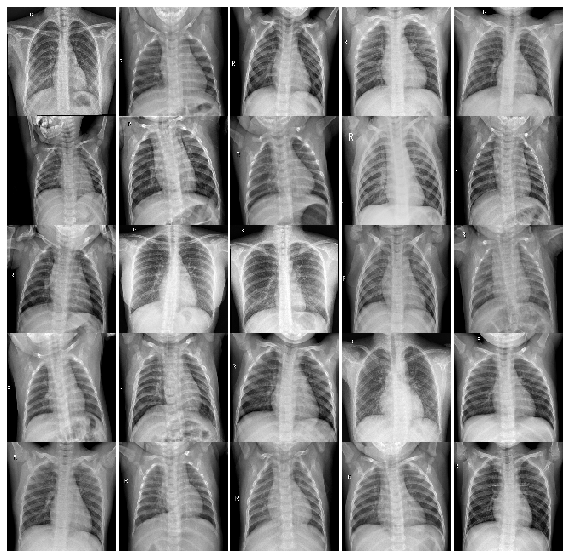

In [219]:
print("Normal")
multipleImages = glob.glob('../Metis/chest_xray/chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0) #no extra space 
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) 
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Pneumonia


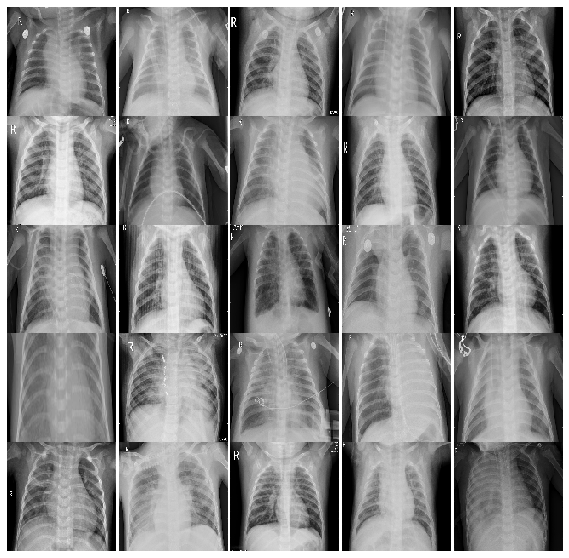

In [220]:
print("Pneumonia")
multipleImages = glob.glob('../Metis/chest_xray/chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) 
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

### Modeling

**Steps to Building a Neural Network** <br>
1. Choose the architecture: <br>
*Layers and Activation functions determine what kinds of patterns the netowrk will detect in your data
 - Number of layers 
 - Types  of layers 
 - Number of Neuronas per layer 
 - Activation Function for each layer
 
 
2. Choose an Optimizer: <br>
*Optimizer algorithms are just variations of Gradient Descent
 - SGD
 - SGD w/momentum
 - Adam
 - Adamgrad
 - RMSprop
 
 
3. Choose a Loss Function:
 - Mean Squared Error
 - Hinge
 - Binary Cross Entropy (Log Loss)
 - Categorical Cross Entropy
 
 
**General Workflow** <br>
-Find an architecture that meets or exceeds your performance goals on the training data (potentially overfitting) <br>
-Introduce regularization (dropout) to force generalization <br>
-If training is too slow: use GPUs to speed up calculation, try transfer learning from pretrained model or from autoencoder <br>

In fit_generator(), you don't pass the x and y directly, instead they come from a generator. 
As it is written in keras documentation, generator is used when you want to avoid duplicate 
data when using multiprocessing. This is for practical purpose, when you have large dataset.

Pooling layers are to decrease computational power needed 

#### Model 1 :

In [221]:
#Set parameters for fitting the model on the data

set_train_steps = 163
set_epoch = 5
set_val_steps = 1

In [181]:
#Conv2D with 2 convolutional layers, 64 units dense layer (64 hidden units)

cnn = Sequential()

# 1st Convolution
cnn.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))   #32 filters, 3x3 filter shape
cnn.add(Activation('relu')) #Activation 
cnn.add(MaxPooling2D(pool_size = (2, 2))) #Pooling


# 2nd Convolution
cnn.add(Conv2D(32, (3, 3))) #don't need input shape since this is an internal layer
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))  # 2nd Pooling layer


# Flatten the layer-need to flatten before we feed into dense layer
cnn.add(Flatten())

        
# Fully Connected Layers
cnn.add(Dense(64))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

# Compile the Neural network
cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [182]:
#Fit model on data

cnn_model = cnn.fit_generator(training_set,
                         steps_per_epoch = set_train_steps, ##these training set/batch size
                         epochs = set_epoch,
                         validation_data = validation_set,
                         validation_steps = set_val_steps)

Epoch 1/5
163/163 [==============================] - 71s 433ms/step - loss: 0.4878 - accuracy: 0.7430 - val_loss: 0.3417 - val_accuracy: 0.8750
Epoch 2/5
163/163 [==============================] - 71s 438ms/step - loss: 0.3261 - accuracy: 0.8637 - val_loss: 0.2375 - val_accuracy: 0.9062
Epoch 3/5
163/163 [==============================] - 70s 431ms/step - loss: 0.2853 - accuracy: 0.8905 - val_loss: 0.0780 - val_accuracy: 0.9688
Epoch 4/5
163/163 [==============================] - 70s 427ms/step - loss: 0.2848 - accuracy: 0.8881 - val_loss: 0.2209 - val_accuracy: 0.9688
Epoch 5/5
163/163 [==============================] - 68s 419ms/step - loss: 0.2772 - accuracy: 0.9005 - val_loss: 0.1850 - val_accuracy: 0.9375


<div class="alert alert-block alert-warning">
<b>Note:</b> Loss seems to be going down still <br>
    Adjust number of epochs in next model to address this 
</div>

#### Model 2:

In [187]:
#Conv2D with 2 conv layers, 64 units dense layer (64 hidden units) 
#Adding 100 epochs with early stopping

cnn = Sequential()

# 1st Convolution
cnn.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
cnn.add(Activation('relu')) #Activation 
cnn.add(MaxPooling2D(pool_size = (2, 2))) #Pooling


# 2nd Convolution
cnn.add(Conv2D(32, (3, 3))) #don't need input shape since this is an internal layer
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))  # 2nd Pooling layer


# Flatten the layer-need to flatten before we feed into dense layer
cnn.add(Flatten())

        
# Fully Connected Layers
cnn.add(Dense(64))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

# Compile the Neural network
cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

cnn_model = cnn.fit_generator(training_set,
                         steps_per_epoch = set_train_steps, ##these training set/batch size
                         epochs = 100,
                         validation_data = validation_set,
                         validation_steps = set_val_steps, 
                        callbacks=[keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

Epoch 1/100
163/163 [==============================] - 64s 395ms/step - loss: 0.4287 - accuracy: 0.7915 - val_loss: 0.2748 - val_accuracy: 0.9375
Epoch 2/100
163/163 [==============================] - 52s 316ms/step - loss: 0.2987 - accuracy: 0.8747 - val_loss: 0.1945 - val_accuracy: 0.9375
Epoch 3/100
163/163 [==============================] - 52s 319ms/step - loss: 0.2623 - accuracy: 0.8962 - val_loss: 0.1045 - val_accuracy: 0.9375
Epoch 4/100
163/163 [==============================] - 51s 311ms/step - loss: 0.2534 - accuracy: 0.9056 - val_loss: 0.1211 - val_accuracy: 0.9688
Epoch 5/100
163/163 [==============================] - 49s 302ms/step - loss: 0.2317 - accuracy: 0.9087 - val_loss: 0.1325 - val_accuracy: 0.9062
Epoch 6/100
163/163 [==============================] - 51s 314ms/step - loss: 0.2240 - accuracy: 0.9149 - val_loss: 0.2316 - val_accuracy: 0.9062
Epoch 7/100
163/163 [==============================] - 51s 311ms/step - loss: 0.2129 - accuracy: 0.9241 - val_loss: 0.0658 -

<div class="alert alert-block alert-warning">
<b>Note:</b> Dropout rate very high <br>
Adjust for next model: 
</div>

#### Model 3: 

In [375]:
#Rerunning model from above but with lower dropout rate (5% instead of 50%)
#100 epochs and early stopping:

#Conv2D with 2 conv layers, 64 units dense layer (64 hidden units)

cnn = Sequential()

# 1st Convolution
cnn.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
cnn.add(Activation('relu')) #Activation 
cnn.add(MaxPooling2D(pool_size = (2, 2))) #Pooling


# 2nd Convolution
cnn.add(Conv2D(32, (3, 3))) #don't need input shape since this is an internal layer
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))  # 2nd Pooling layer


# Flatten the layer-need to flatten before we feed into dense layer
cnn.add(Flatten())

        
# Fully Connected Layers
cnn.add(Dense(64))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.05))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

# Compile the Neural network
cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

cnn_model = cnn.fit_generator(training_set,
                         steps_per_epoch = set_train_steps, #samples/batch_size--diff now with 128
                         epochs = 100,
                         validation_data = validation_set,
                         validation_steps = set_val_steps, #currently 1
                         callbacks=[keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

Epoch 1/100
163/163 [==============================] - 234s 1s/step - loss: 0.3095 - accuracy: 0.8648 - val_loss: 0.1815 - val_accuracy: 0.9375
Epoch 2/100
163/163 [==============================] - 200s 1s/step - loss: 0.2019 - accuracy: 0.9193 - val_loss: 0.1214 - val_accuracy: 0.9609
Epoch 3/100
163/163 [==============================] - 202s 1s/step - loss: 0.1800 - accuracy: 0.9311 - val_loss: 0.1750 - val_accuracy: 0.9453
Epoch 4/100
163/163 [==============================] - 201s 1s/step - loss: 0.1608 - accuracy: 0.9371 - val_loss: 0.1344 - val_accuracy: 0.9609
Epoch 5/100
163/163 [==============================] - 208s 1s/step - loss: 0.1455 - accuracy: 0.9437 - val_loss: 0.1872 - val_accuracy: 0.9141
Epoch 6/100
163/163 [==============================] - 229s 1s/step - loss: 0.1375 - accuracy: 0.9471 - val_loss: 0.1924 - val_accuracy: 0.9453
Epoch 7/100
163/163 [==============================] - 248s 2s/step - loss: 0.1295 - accuracy: 0.9493 - val_loss: 0.0819 - val_accuracy:

<div class="alert alert-block alert-success">
<b>Note:</b> So far this seems to be best model
</div>

In [376]:
#Get Summary from Final Model 
cnn.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
activation_105 (Activation)  (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_106 (Activation)  (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 6272)            

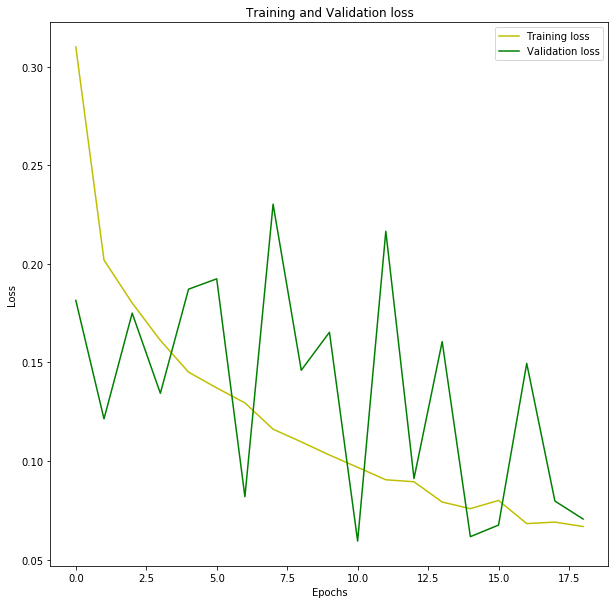

In [393]:
#Graph loss for training and validation 
loss_train = cnn_model.history['loss']
loss_val = cnn_model.history['val_loss']
epochs = range(0,19)
plt.plot(epochs, loss_train, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

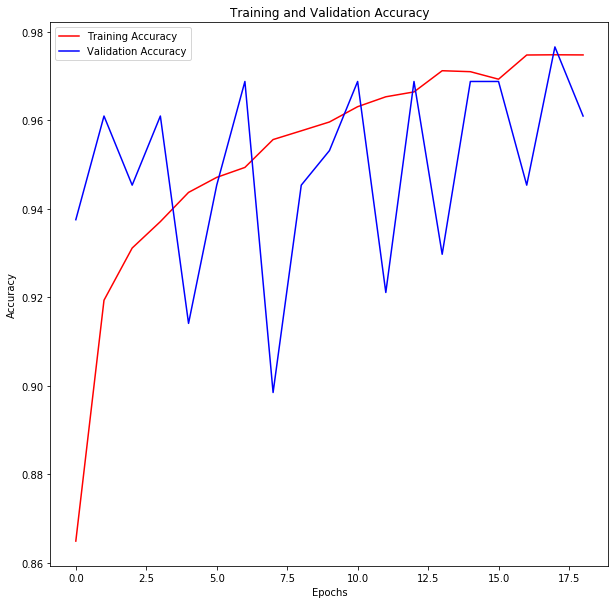

In [416]:
#Graph accuracy for training and validation 
accuracy_train = cnn_model.history['accuracy']
accuracy_val = cnn_model.history['val_accuracy']
epochs = range(0,19)
plt.plot(epochs, accuracy_train, 'r', label='Training Accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')

#### Accuracy and Confusion Matrices 

In [384]:
#Training and validation accuracy 
train_accuracy = cnn.evaluate_generator(training_set, steps = 100)
print('The training accuracy is :',round(train_accuracy[1]*100), '%')

val_accuracy = cnn.evaluate_generator(validation_set, steps = 100)
print('The validation accuracy is :',round(val_accuracy[1]*100), '%')

The training accuracy is : 97.0 %
The validation accuracy is : 96.0 %


In [386]:
#Run this on test set 
test_accuracy = cnn.evaluate_generator(test_set,steps=100)
print('The testing accuracy is :',round(test_accuracy[1]*100), '%')

The testing accuracy is : 90.0 %


In [387]:
#Calculate confusion matrix for training data 
training_set.reset()
Y_pred = cnn.predict_generator(training_set)
y_pred = np.rint(Y_pred.flatten())
cm = confusion_matrix(training_set.classes[training_set.index_array], y_pred)

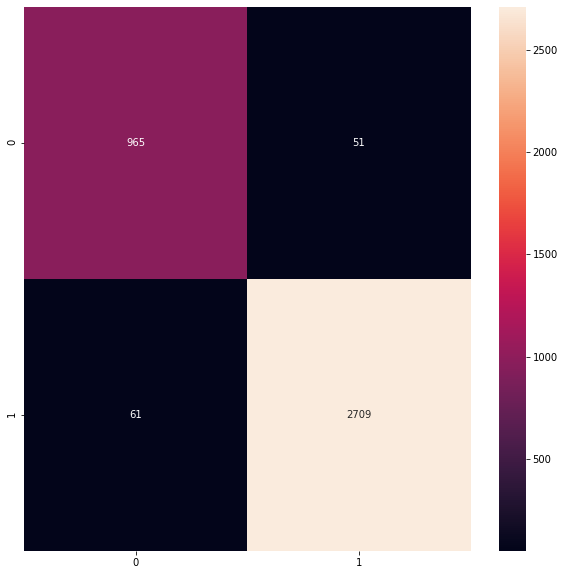

In [397]:
#Heatmap of confusion matrix-training
cm1 = sns.heatmap(cm, annot=True, fmt='g')

In [400]:
cm1.get_figure().savefig('confmatrix_train.png', dpi=400)

In [389]:
#Confusion matrix of validation data
validation_set.reset()
Y_pred = cnn.predict_generator(validation_set)
y_pred = np.rint(Y_pred.flatten())
cm_val= confusion_matrix(validation_set.classes[validation_set.index_array], y_pred)

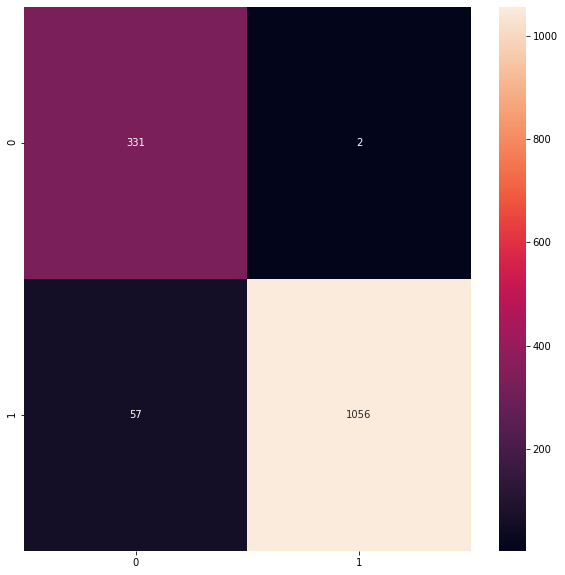

In [401]:
cm2=sns.heatmap(cm_val, annot=True, fmt='g')

In [403]:
cm2.get_figure().savefig('confmatrix_val.png', dpi=400)

In [428]:
#Confusion Matrix of test data 
test_set.reset()
Y_pred = cnn.predict_generator(test_set)
y_pred = np.rint(Y_pred.flatten())

cm_test=confusion_matrix(test_set.classes[test_set.index_array],y_pred)

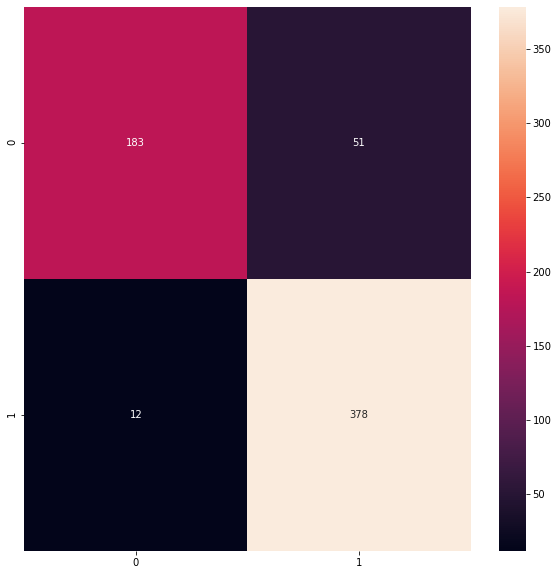

In [429]:
figure = sns.heatmap(cm_test, annot=True, fmt='g')
figure.get_figure().savefig('confmatrix_test.png', dpi=400)

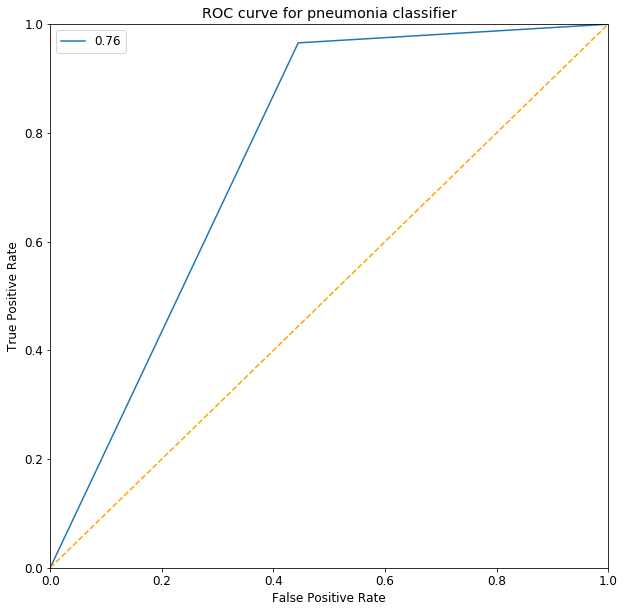

In [482]:
#Plot ROC curve 
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr,label=auc)
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.rcParams['font.size'] = 12
plt.title('ROC curve for pneumonia classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('ROC_cnn.png')

In [469]:
auc=round(metrics.roc_auc_score(y_test, y_pred), 2) #round to two decimal places 
auc

0.76

#### More Model Tuning 

#### Model 4: 

In [335]:
#Rerunning model 3 with Batch Normalization 
#100 epochs and early stopping:

#Conv2D with 2 conv layers, 64 units dense layer (64 hidden units)

cnn = Sequential()

# 1st Convolution
cnn.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu')) #Activation 
cnn.add(MaxPooling2D(pool_size = (2, 2))) #Pooling


# 2nd Convolution
cnn.add(Conv2D(32, (3, 3))) #don't need input shape since this is an internal layer
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))  # 2nd Pooling layer


# Flatten the layer-need to flatten before we feed into dense layer
cnn.add(Flatten())

        
# Fully Connected Layers
cnn.add(Dense(64))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.05))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

# Compile the Neural network
cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

cnn_model = cnn.fit_generator(training_set,
                         steps_per_epoch = set_train_steps, #samples/batch_size--diff now with 128
                         epochs = 100,
                         validation_data = validation_set,
                         validation_steps = set_val_steps, #currently 1--change??
                         callbacks=[keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

Epoch 1/100
163/163 [==============================] - 211s 1s/step - loss: 0.2527 - accuracy: 0.9029 - val_loss: 1.2158 - val_accuracy: 0.8125
Epoch 2/100
163/163 [==============================] - 196s 1s/step - loss: 0.1383 - accuracy: 0.9478 - val_loss: 2.2108 - val_accuracy: 0.7500
Epoch 3/100
163/163 [==============================] - 200s 1s/step - loss: 0.1186 - accuracy: 0.9571 - val_loss: 1.0754 - val_accuracy: 0.7422
Epoch 4/100
163/163 [==============================] - 207s 1s/step - loss: 0.1014 - accuracy: 0.9631 - val_loss: 0.1129 - val_accuracy: 0.9609
Epoch 5/100
163/163 [==============================] - 248s 2s/step - loss: 0.0872 - accuracy: 0.9673 - val_loss: 1.2174 - val_accuracy: 0.5000
Epoch 6/100
163/163 [==============================] - 238s 1s/step - loss: 0.0860 - accuracy: 0.9669 - val_loss: 0.0490 - val_accuracy: 0.9766
Epoch 7/100
163/163 [==============================] - 236s 1s/step - loss: 0.0761 - accuracy: 0.9724 - val_loss: 0.2016 - val_accuracy:

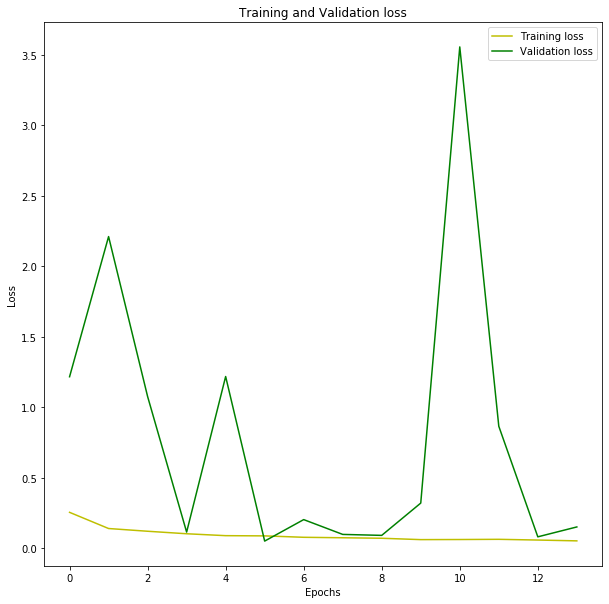

In [339]:
#Plot with loss data from 14 epochs
loss_train = cnn_model.history['loss']
loss_val = cnn_model.history['val_loss']
epochs = range(0,14) #adjust this
plt.plot(epochs, loss_train, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

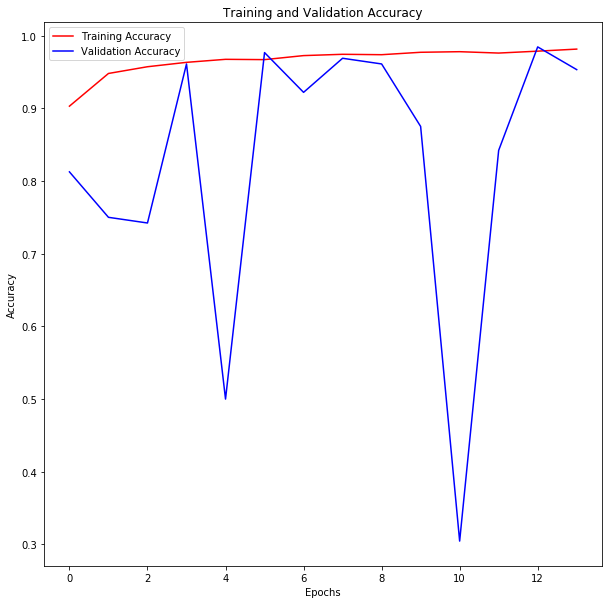

In [340]:
#Plot with accuracy data from 14 epochs
#Graph accuracy for training and validation 
accuracy_train = cnn_model.history['accuracy']
accuracy_val = cnn_model.history['val_accuracy']
epochs = range(0,14) 
plt.plot(epochs, accuracy_train, 'r', label='Training Accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">
<b>Note:</b> Batch normalization caused more volatility in validation data <br> 
</div>

#### Model 5: 

In [342]:
#Rerunning model 3 
#100 epochs:

#Conv2D with 2 conv layers, 64 units dense layer (64 hidden units)

cnn = Sequential()

# 1st Convolution
cnn.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
cnn.add(Activation('relu')) #Activation 
cnn.add(MaxPooling2D(pool_size = (2, 2))) #Pooling


# 2nd Convolution
cnn.add(Conv2D(32, (3, 3))) #don't need input shape since this is an internal layer
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))  # 2nd Pooling layer


# Flatten the layer-need to flatten before we feed into dense layer
cnn.add(Flatten())

        
# Fully Connected Layers
cnn.add(Dense(64))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.05))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

# Compile the Neural network
cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

cnn_model3 = cnn.fit_generator(training_set,
                         steps_per_epoch = set_train_steps, #samples/batch_size--diff now with 128
                         epochs = 100,
                         validation_data = validation_set,
                         validation_steps = set_val_steps) #currently 1--change??

Epoch 1/100
163/163 [==============================] - 250s 2s/step - loss: 0.3264 - accuracy: 0.8586 - val_loss: 0.1747 - val_accuracy: 0.9219
Epoch 2/100
163/163 [==============================] - 254s 2s/step - loss: 0.2126 - accuracy: 0.9115 - val_loss: 0.1296 - val_accuracy: 0.9453
Epoch 3/100
163/163 [==============================] - 256s 2s/step - loss: 0.1728 - accuracy: 0.9331 - val_loss: 0.1556 - val_accuracy: 0.9297
Epoch 4/100
163/163 [==============================] - 254s 2s/step - loss: 0.1645 - accuracy: 0.9361 - val_loss: 0.0997 - val_accuracy: 0.9609
Epoch 5/100
163/163 [==============================] - 256s 2s/step - loss: 0.1510 - accuracy: 0.9422 - val_loss: 0.0895 - val_accuracy: 0.9766
Epoch 6/100
163/163 [==============================] - 253s 2s/step - loss: 0.1300 - accuracy: 0.9499 - val_loss: 0.1494 - val_accuracy: 0.9375
Epoch 7/100
163/163 [==============================] - 254s 2s/step - loss: 0.1324 - accuracy: 0.9501 - val_loss: 0.0842 - val_accuracy:

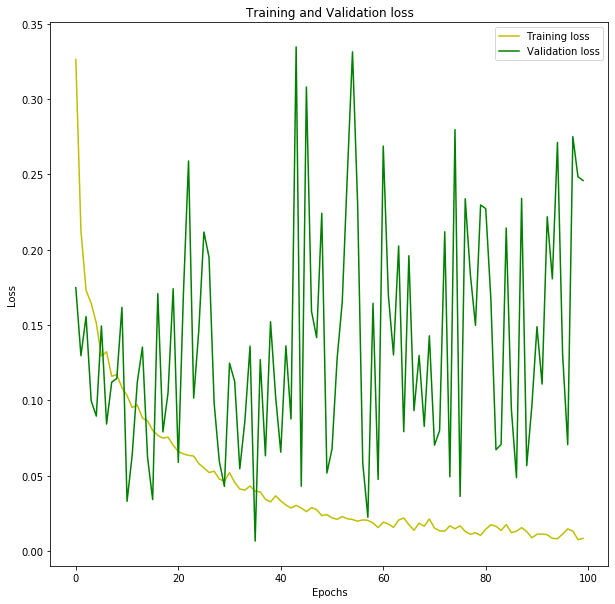

In [343]:
#Plot with loss data from 100 epochs
loss_train = cnn_model3.history['loss']
loss_val = cnn_model3.history['val_loss']
epochs = range(0,100)
plt.plot(epochs, loss_train, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

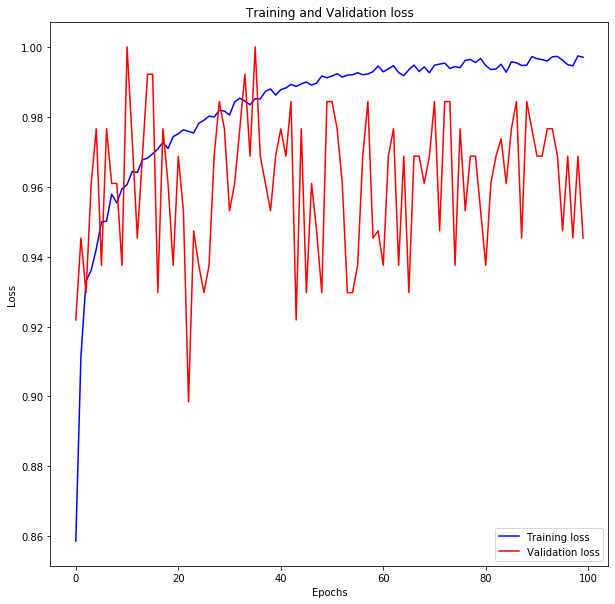

In [351]:
#Plot with loss data from 100 epochs
acc_train = cnn_model3.history['accuracy']
acc_val = cnn_model3.history['val_accuracy']
epochs = range(0,100) 
plt.plot(epochs, acc_train, 'b', label='Training loss')
plt.plot(epochs, acc_val, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_set.reset()
Y_pred = cnn.predict_generator(test_set)
y_pred = np.rint(Y_pred.flatten())

cm_test=confusion_matrix(test_set.classes[test_set.index_array],y_pred)

<div class="alert alert-block alert-warning">
<b>Note:</b> Running 100 epochs to see trend does not improve graph much--stick to early stopping because trends in validation data follow training data more closely <br> 
</div>

#### Model 6: 

In [354]:
#Rerunning model from above but no dropout
#100 epochs and early stopping:

#Conv2D with 2 conv layers, 64 units dense layer (64 hidden units)

cnn = Sequential()

# 1st Convolution
cnn.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
cnn.add(Activation('relu')) #Activation 
cnn.add(MaxPooling2D(pool_size = (2, 2))) #Pooling


# 2nd Convolution
cnn.add(Conv2D(32, (3, 3))) #don't need input shape since this is an internal layer
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))  # 2nd Pooling layer


# Flatten the layer-need to flatten before we feed into dense layer
cnn.add(Flatten())

        
# Fully Connected Layers
cnn.add(Dense(64))
cnn.add(Activation('relu'))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))

# Compile the Neural network
cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

cnn_model4 = cnn.fit_generator(training_set,
                         steps_per_epoch = set_train_steps, #samples/batch_size--diff now with 128
                         epochs = 100,
                         validation_data = validation_set,
                         validation_steps = set_val_steps, #currently 1--change??
                         callbacks=[keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

Epoch 1/100
163/163 [==============================] - 259s 2s/step - loss: 0.2993 - accuracy: 0.8666 - val_loss: 0.2462 - val_accuracy: 0.8984
Epoch 2/100
163/163 [==============================] - 228s 1s/step - loss: 0.1916 - accuracy: 0.9237 - val_loss: 0.1404 - val_accuracy: 0.9609
Epoch 3/100
163/163 [==============================] - 204s 1s/step - loss: 0.1722 - accuracy: 0.9310 - val_loss: 0.1204 - val_accuracy: 0.9609
Epoch 4/100
163/163 [==============================] - 206s 1s/step - loss: 0.1574 - accuracy: 0.9399 - val_loss: 0.1283 - val_accuracy: 0.9453
Epoch 5/100
163/163 [==============================] - 205s 1s/step - loss: 0.1353 - accuracy: 0.9477 - val_loss: 0.1231 - val_accuracy: 0.9531
Epoch 6/100
163/163 [==============================] - 207s 1s/step - loss: 0.1347 - accuracy: 0.9488 - val_loss: 0.0728 - val_accuracy: 0.9844
Epoch 7/100
163/163 [==============================] - 203s 1s/step - loss: 0.1282 - accuracy: 0.9512 - val_loss: 0.2231 - val_accuracy:

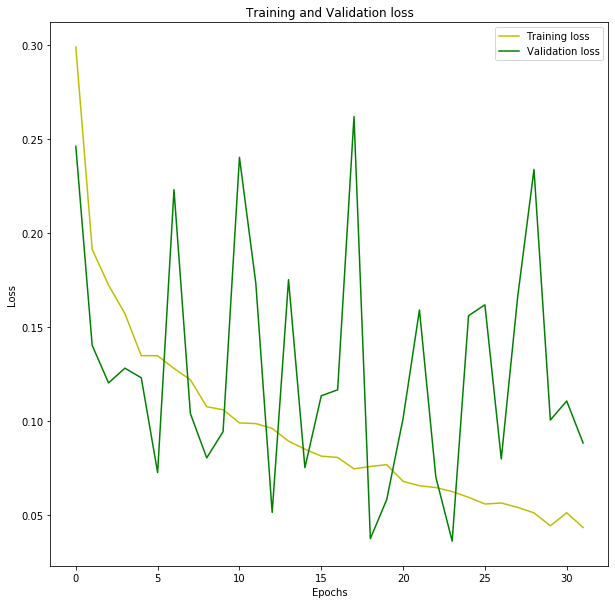

In [355]:
#Plot with loss data from 32 epochs
loss_train = cnn_model4.history['loss']
loss_val = cnn_model4.history['val_loss']
epochs = range(0,32)
plt.plot(epochs, loss_train, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

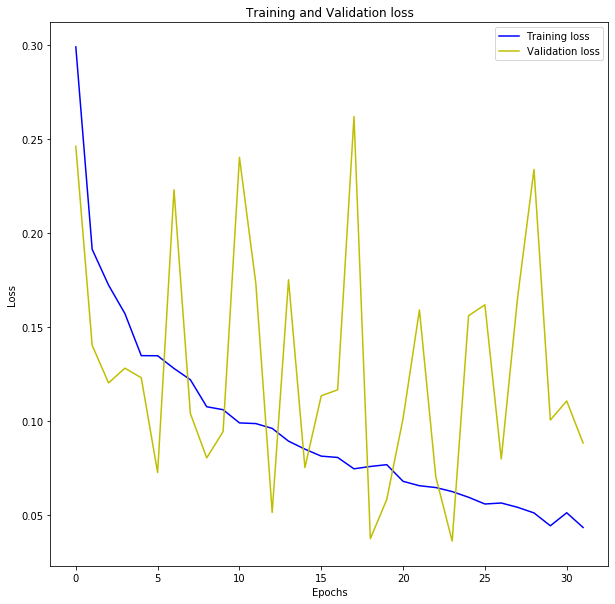

In [357]:
#Plot with loss data from 32 epochs
acc_train = cnn_model4.history['accuracy']
acc_val = cnn_model4.history['val_accuracy']
epochs = range(0,32)
plt.plot(epochs, loss_train, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'y', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">
<b>Note:</b> No dropout did not improve trends in validation data <br> 
</div>

<div class="alert alert-block alert-success">
<b>Note:</b> Use Model 3 for final model to calculate metric
</div>